<a href="https://colab.research.google.com/github/wayrayfr/2025-2-URP3/blob/main/URP3_waste.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import numpy as np

In [31]:
filter = pd.read_csv('/content/drive/MyDrive/2025/URP/data/filter_paper.csv')
A1 = pd.read_csv('/content/drive/MyDrive/2025/URP/data/A1.csv')
F1 = pd.read_csv('/content/drive/MyDrive/2025/URP/data/F1.csv')
O1 = pd.read_csv('/content/drive/MyDrive/2025/URP/data/O1.csv')
S1 = pd.read_csv('/content/drive/MyDrive/2025/URP/data/S1.csv')

In [20]:
A1

,3996.37951,0.99982
0,3994.45076,0.99982
1,3992.52201,0.99982
2,3990.59325,0.99982
3,3988.66450,0.99982
4,3986.73574,0.99982
...,...,...
1756,607.55770,0.98845
1757,605.62894,0.98845
1758,603.70019,0.98845
1759,601.77143,0.98845


In [33]:
def transform_wavelength_data(df):
    """
    파장 데이터를 변환하는 함수

    Parameters:
    df: DataFrame with 2 or 3 columns (wavelength, signal) or (index, wavelength, signal)

    Returns:
    transformed_df: 파장이 열이 되고 시그널이 값이 되는 DataFrame
    """
    # 데이터프레임 복사
    df_copy = df.copy()

    # 이미 변환된 데이터프레임인지 확인 (열이 많으면 이미 변환된 것)
    if len(df_copy.columns) > 10:
        print(f"  이미 변환된 형태입니다. (열 개수: {len(df_copy.columns)})")
        # 파장(열 이름)을 내림차순으로 정렬
        df_copy = df_copy[sorted(df_copy.columns, reverse=True)]
        return df_copy

    # 열 개수에 따라 처리
    if len(df_copy.columns) == 2:
        # 2개 열: 파장, 시그널
        df_copy.columns = ['wavelength', 'signal']
    elif len(df_copy.columns) == 3:
        # 3개 열: 인덱스, 파장, 시그널
        df_copy.columns = ['index', 'wavelength', 'signal']
    else:
        raise ValueError(f"Expected 2 or 3 columns, got {len(df_copy.columns)}")

    # 파장을 정수로 반올림
    df_copy['wavelength_rounded'] = df_copy['wavelength'].round().astype(int)

    # 시그널값 그대로 사용
    df_copy['signal_adjusted'] = df_copy['signal']

    # 반올림된 파장의 최소값과 최대값 찾기
    min_wavelength = df_copy['wavelength_rounded'].min()
    max_wavelength = df_copy['wavelength_rounded'].max()

    # 모든 정수 파장 생성
    all_wavelengths = np.arange(min_wavelength, max_wavelength + 1)

    # 각 파장에 대한 시그널값 매핑
    wavelength_to_signal = {}

    for wavelength in all_wavelengths:
        # 해당 파장값이 데이터에 있는지 확인
        matching_rows = df_copy[df_copy['wavelength_rounded'] == wavelength]

        if len(matching_rows) > 0:
            # 해당 파장이 있으면 평균값 사용
            wavelength_to_signal[wavelength] = matching_rows['signal_adjusted'].mean()
        else:
            # 없으면 선형 보간
            # 이전 파장과 다음 파장 찾기
            lower_wavelengths = df_copy[df_copy['wavelength_rounded'] < wavelength]
            upper_wavelengths = df_copy[df_copy['wavelength_rounded'] > wavelength]

            if len(lower_wavelengths) > 0 and len(upper_wavelengths) > 0:
                # 가장 가까운 이전 파장과 다음 파장
                lower_wl = lower_wavelengths['wavelength_rounded'].max()
                upper_wl = upper_wavelengths['wavelength_rounded'].min()

                lower_signal = df_copy[df_copy['wavelength_rounded'] == lower_wl]['signal_adjusted'].mean()
                upper_signal = df_copy[df_copy['wavelength_rounded'] == upper_wl]['signal_adjusted'].mean()

                # 선형 보간
                interpolated_signal = lower_signal + (upper_signal - lower_signal) * \
                                     (wavelength - lower_wl) / (upper_wl - lower_wl)
                wavelength_to_signal[wavelength] = interpolated_signal
            elif len(lower_wavelengths) > 0:
                # 상한만 없으면 마지막 값 사용
                wavelength_to_signal[wavelength] = lower_wavelengths['signal_adjusted'].iloc[-1]
            elif len(upper_wavelengths) > 0:
                # 하한만 없으면 첫 값 사용
                wavelength_to_signal[wavelength] = upper_wavelengths['signal_adjusted'].iloc[0]

    # 결과 DataFrame 생성 (파장이 열이 됨)
    result_df = pd.DataFrame([wavelength_to_signal])

    # 열을 파장 기준으로 내림차순 정렬
    result_df = result_df[sorted(result_df.columns, reverse=True)]

    return result_df


# 사용 예시
if __name__ == "__main__":
    # 데이터프레임 리스트 (A1, filter, S1, O1, F1)
    dataframe_names = ['A1', 'filter', 'S1', 'O1', 'F1']

    # 각 데이터프레임에 대해 변환 수행 (원본을 덮어씀)
    for name in dataframe_names:
        if name in globals():
            print(f"\n=== {name} 데이터프레임 변환 중 ===")
            globals()[name] = transform_wavelength_data(globals()[name])
            print(f"{name} 변환 완료!")

    # 테스트 예시 (2열 데이터)
    print("\n=== 테스트 예시 (2열) ===")
    test_data_2col = pd.DataFrame({
        'wavelength': [3996.37951, 3994.45076, 3992.52201, 3990.59325, 3988.66450],
        'signal': [0.99982, 0.99982, 0.99982, 0.99982, 0.99982]
    })

    result = transform_wavelength_data(test_data_2col)
    print(f"\n변환 결과 (일부):")
    print(result.iloc[:, :10])  # 첫 10개 열만 표시
    print(f"\n총 열 개수: {len(result.columns)}")
    print(f"파장 범위: {result.columns[0]} ~ {result.columns[-1]}")

    # 테스트 예시 (3열 데이터)
    print("\n=== 테스트 예시 (3열) ===")
    test_data_3col = pd.DataFrame({
        'index': [0, 1, 2, 3, 4],
        'wavelength': [3996.37951, 3994.45076, 3992.52201, 3990.59325, 3988.66450],
        'signal': [0.99982, 0.99982, 0.99982, 0.99982, 0.99982]
    })

    result2 = transform_wavelength_data(test_data_3col)
    print(f"\n변환 결과 (일부):")
    print(result2.iloc[:, :10])  # 첫 10개 열만 표시


=== A1 데이터프레임 변환 중 ===
A1 변환 완료!

=== filter 데이터프레임 변환 중 ===
filter 변환 완료!

=== S1 데이터프레임 변환 중 ===
S1 변환 완료!

=== O1 데이터프레임 변환 중 ===
O1 변환 완료!

=== F1 데이터프레임 변환 중 ===
F1 변환 완료!

=== 테스트 예시 (2열) ===

변환 결과 (일부):
      3996     3995     3994     3993     3992     3991     3990     3989
0  0.99982  0.99982  0.99982  0.99982  0.99982  0.99982  0.99982  0.99982

총 열 개수: 8
파장 범위: 3996 ~ 3989

=== 테스트 예시 (3열) ===

변환 결과 (일부):
      3996     3995     3994     3993     3992     3991     3990     3989
0  0.99982  0.99982  0.99982  0.99982  0.99982  0.99982  0.99982  0.99982


In [35]:
A1

,3994,3993,3992,3991,3990,3989,3988,3987,3986,3985,...,609,608,607,606,605,604,603,602,601,600
0,0.99982,0.99982,0.99982,0.99982,0.99982,0.99982,0.99982,0.99982,0.99982,0.99982,...,0.98845,0.98845,0.98845,0.98845,0.98845,0.98845,0.98845,0.98845,0.98845,0.98845


In [36]:
filter

,3994,3993,3992,3991,3990,3989,3988,3987,3986,3985,...,609,608,607,606,605,604,603,602,601,600
0,0.99941,0.99941,0.99941,0.99941,0.99941,0.99941,0.99941,0.99941,0.99941,0.99941,...,0.99552,0.99552,0.99552,0.99552,0.99552,0.99552,0.99552,0.99552,0.99552,0.99552


In [42]:
def make_global_region_mask_from_filter(filter_df_T,
                                        q_filter=0.9,
                                        min_points=50):
    """
    filter_df_T : 1×N DataFrame (필터 Transmittance)
    q_filter    : 필터 absorbance 상위 몇 %를 region 으로 쓸지 (0.9 = 상위 10%)
    min_points  : 너무 적게 뽑혔을 때 fallback 으로 쓸 최소 포인트 수
    """
    # 컬럼 정렬 (원래 타입 그대로 유지: int면 int, float면 float)
    cols = sorted(filter_df_T.columns, key=lambda x: float(x))
    filter_T = filter_df_T[cols]

    # T -> A
    filter_A_df = transmittance_to_absorbance(filter_T)
    filter_A = filter_A_df.iloc[0].values

    # 파수는 float 배열로 따로 보관
    wn = np.array([float(c) for c in cols], dtype=float)

    # 필터 피크 강한 구간: 상위 q_filter quantile
    thr = np.quantile(filter_A, q_filter)
    mask = filter_A >= thr

    if mask.sum() < min_points:
        mask = filter_A > 0

    used_wn = wn[mask]
    print(f"[GLOBAL] region: {mask.sum()} points 사용 "
          f"({used_wn.min():.1f} ~ {used_wn.max():.1f} cm-1 근처)")

    # cols: 실제 DF에서 사용할 컬럼 이름 (int/float 그대로)
    return cols, wn, filter_A, mask


In [43]:
def subtract_with_global_mask(sample_df_T, cols, filter_A, wn, mask,
                              return_T=True):
    """
    sample_df_T : 1×N DataFrame (sample+filter, T)
    cols        : make_global_region_mask_from_filter 가 반환한 컬럼 리스트
    filter_A    : 1D numpy array (필터 absorbance, cols/wn 과 align)
    wn          : 1D numpy array (파수, float)  -- 여기선 쓰진 않지만 보관용
    mask        : boolean mask (global region)
    """
    # 컬럼 타입을 건드리지 않고 그대로 사용
    sample_T = sample_df_T[cols]

    sample_A_df = transmittance_to_absorbance(sample_T)
    sample_A = sample_A_df.iloc[0].values

    # 최소제곱으로 k 계산
    x = filter_A[mask]
    y = sample_A[mask]
    denom = np.sum(x**2)
    if denom == 0:
        raise ValueError("mask 구간에서 filter_A가 0입니다.")
    k = np.sum(y * x) / denom

    # 전체 파수에서 subtraction
    result_A = sample_A - k * filter_A

    if return_T:
        result_T = 10 ** (-result_A)
        result_df = pd.DataFrame([result_T], columns=cols)
    else:
        result_df = pd.DataFrame([result_A], columns=cols)

    return result_df, k


In [44]:
# 1) 필터에서 global region 한 번 계산
cols, wn, filter_A, global_mask = make_global_region_mask_from_filter(
    filter,          # 필터 DataFrame
    q_filter=0.9,    # 상위 10%만 region으로 사용 (원하면 조절)
    min_points=50
)

# 2) 각 시료에 같은 mask로 필터 제거
A1_sub, k_A1 = subtract_with_global_mask(A1, cols, filter_A, wn, global_mask)
O1_sub, k_O1 = subtract_with_global_mask(O1, cols, filter_A, wn, global_mask)
F1_sub, k_F1 = subtract_with_global_mask(F1, cols, filter_A, wn, global_mask)
S1_sub, k_S1 = subtract_with_global_mask(S1, cols, filter_A, wn, global_mask)

print("A1 k =", k_A1)
print("O1 k =", k_O1)
print("F1 k =", k_F1)
print("S1 k =", k_S1)


[GLOBAL] region: 340 points 사용 (668.0 ~ 3407.0 cm-1 근처)
A1 k = 1.2324545460307517
O1 k = 1.2494636011225384
F1 k = 1.1433637701681092
S1 k = 1.2864963815314696


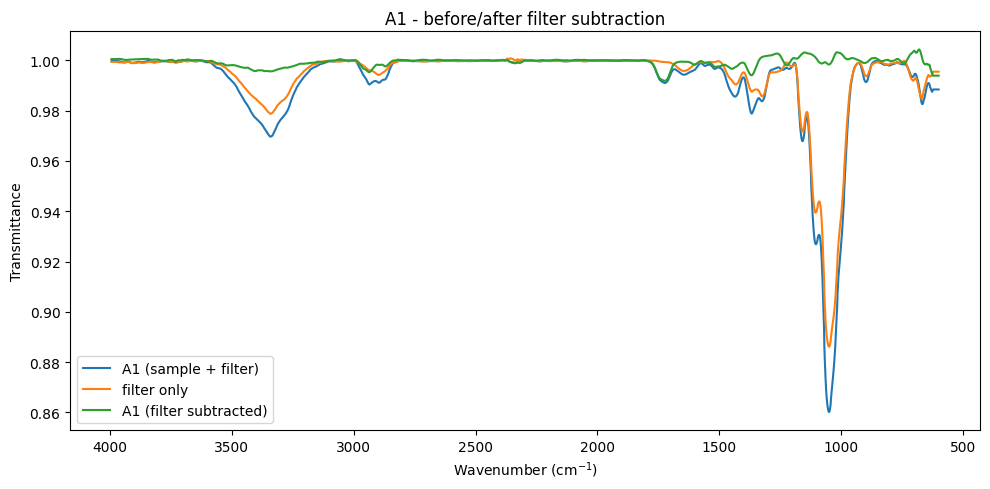

In [45]:
import matplotlib.pyplot as plt

def plot_before_after(sample_df_T, sample_sub_df_T, filter_df_T, title="A1"):
    cols = sorted(sample_df_T.columns, key=lambda x: float(x))
    wn = [float(c) for c in cols]

    sample_T = sample_df_T[cols].iloc[0].values
    sub_T    = sample_sub_df_T[cols].iloc[0].values
    filter_T = filter_df_T[cols].iloc[0].values

    plt.figure(figsize=(10,5))
    plt.plot(wn, sample_T, label=f"{title} (sample + filter)")
    plt.plot(wn, filter_T, label="filter only")
    plt.plot(wn, sub_T,    label=f"{title} (filter subtracted)")
    plt.gca().invert_xaxis()
    plt.xlabel("Wavenumber (cm$^{-1}$)")
    plt.ylabel("Transmittance")
    plt.legend()
    plt.title(f"{title} - before/after filter subtraction")
    plt.tight_layout()
    plt.show()

# A1 예시
plot_before_after(A1, A1_sub, filter, title="A1")


In [46]:
save_path = "/content/drive/MyDrive/2025/URP/data/"
A1_sub.to_csv(save_path + "A1_sub.csv", index=False)
O1_sub.to_csv(save_path + "O1_sub.csv", index=False)
F1_sub.to_csv(save_path + "F1_sub.csv", index=False)
S1_sub.to_csv(save_path + "S1_sub.csv", index=False)